## Imports and stting functions

In [1]:
# Clone code from GitHub
!git clone https://github.com/IdoRavid/AdamOptimizationProject.git /content/project 2>/dev/null || (cd /content/project && git pull)
%cd /content/project

# Mount Drive for saving results
from google.colab import drive
drive.mount('/content/drive')
RESULTS_DIR = '/content/drive/MyDrive/Optimization Project/results/'
!mkdir -p "$RESULTS_DIR"

import sys
sys.path.insert(0, 'src')

/content/project
Mounted at /content/drive


In [2]:
# @title Imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
# @title Data Loader
print("Loading Data...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
x_train = train_data.data
x_test = test_data.data
image_size = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape(-1, image_size).float() / 255
x_test = x_test.reshape(-1, image_size).float() / 255

Loading Data...


In [4]:
# @title AutoEncoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, image_size), nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
#init autoencoder
autoencoder = Autoencoder()

## oracle functions
you should use to given model, loss function and x returns either the model output, the loss, the gradient and the hessian.

In [5]:
def autoencoder_oracle(model, criterion, x, calc_hessian=False):
    """
    Computes f(x), gradient, and Hessian for a given input x.
    """
    # Forward Pass
    reconstructed_x = model(x)
    loss = criterion(reconstructed_x, x)

    grads = torch.autograd.grad(loss, model.parameters(), create_graph=calc_hessian)

    hessians = []

    if calc_hessian:
        for i, (grad, param) in enumerate(zip(grads, model.parameters())):

            grad_flat = grad.view(-1)

            hessian_rows = []
            for j in range(len(grad_flat)):

                grad_2nd = torch.autograd.grad(grad_flat[j], param, retain_graph=True)[0]
                hessian_rows.append(grad_2nd.view(-1))

            hessian_matrix = torch.stack(hessian_rows)
            hessians.append(hessian_matrix)


    return loss, grads, hessians

In [ ]:
print("Initializing the model (Defining the function surface)...")
train_dataset = TensorDataset(x_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# This dataset is for the second order learners - so you wont run out of RAM
small_train_dataset = TensorDataset(x_train[:100]) # רק 100 תמונות להדגמה
small_train_loader = DataLoader(small_train_dataset, batch_size=10, shuffle=True)



Initializing the model (Defining the function surface)...


## Examples for optimizers

In [ ]:
def gd_step(x, grad_f_x, learning_rate=0.1):
    """
    Performs one step of Gradient Descent.
    Formula: x_new = x - lr * gradient
    """
    x_new = x - learning_rate * grad_f_x

    return x_new

In [ ]:
def newton_step(x, grad_f_x, hessian_f_x, learning_rate=1.0):
    """
    Performs one step of Newton-Raphson optimization on a batch.
    Shapes:
      x: (Batch, Dim)
      grad_f_x: (Batch, Dim)
      hessian_f_x: (Batch, Dim, Dim)
    """
    # 1. Calculate Inverse Hessian
    # torch.linalg.pinv handles batch dimensions automatically (Batch, D, D)
    hessian_inv = torch.linalg.pinv(hessian_f_x)

    # 2. Prepare Gradient for Batch Matrix Multiplication
    # grad_f_x is (Batch, D). We need (Batch, D, 1) for matmul
    grad_unsqueezed = grad_f_x.unsqueeze(2)

    # 3. Compute Update Direction: H^-1 * Gradient
    # (Batch, D, D) x (Batch, D, 1) -> (Batch, D, 1)
    update_direction = torch.matmul(hessian_inv, grad_unsqueezed)

    # 4. Remove extra dimension: (Batch, D, 1) -> (Batch, D)
    update_direction = update_direction.squeeze(2)

    # 5. Apply Update
    x_new = x - learning_rate * update_direction

    return x_new

In [ ]:
def run_model_optimization_experiment(
    optimizer_type: str,
    model: nn.Module,
    criterion: nn.Module,
    train_loader: DataLoader,
    epochs: int,
    learning_rate: float
):
    """
    Runs an optimization experiment to train the MODEL using GD or Newton.
    Closer to the requested structure.
    """
    all_losses = []
    print(f"\nStarting MODEL {optimizer_type.upper()} optimization for {epochs} epochs (lr={learning_rate})...")
    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            img = batch[0]

            calc_hessian_for_oracle = (optimizer_type == 'newton')
            loss, grads, hessians = autoencoder_oracle(model, criterion, img, calc_hessian=calc_hessian_for_oracle)

            epoch_loss += loss.item()

            # 2. Optimization step
            with torch.no_grad():
                if optimizer_type == 'gd':
                    for param, grad in zip(model.parameters(), grads):
                        param.data = gd_step(param.data, grad, learning_rate)

                elif optimizer_type == 'newton':
                    if hessians is None:
                        raise ValueError("Hessian missing for Newton method")
                    for param, grad, hessian in zip(model.parameters(), grads, hessians):
                        param.data = newton_step(param.data, grad, hessian, learning_rate)

                else:
                    raise ValueError("Invalid optimizer type")

        avg_loss = epoch_loss / len(train_loader)
        all_losses.append(avg_loss)


        if (epoch + 1) % (epochs // 5) == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"  Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.6f}")

    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f"\nTotal Training Time: {total_training_time:.2f} seconds")
    print(f"Finished {optimizer_type.upper()} optimization. Final Loss: {all_losses[-1]:.6f}")
    return model, all_losses

In [ ]:
epochs = 10
lr = 0.1
model = Autoencoder()
criterion = nn.MSELoss()

trained_model, losses = run_model_optimization_experiment(
    'gd', model, criterion, train_loader, epochs, lr
)


Starting MODEL GD optimization for 10 epochs (lr=0.1)...
  Epoch [1/10] Loss: 0.168506
  Epoch [2/10] Loss: 0.161498
  Epoch [4/10] Loss: 0.091319
  Epoch [6/10] Loss: 0.084263
  Epoch [8/10] Loss: 0.081242
  Epoch [10/10] Loss: 0.079776
Finished GD optimization. Final Loss: 0.079776


### Loss Curves Over Epochs

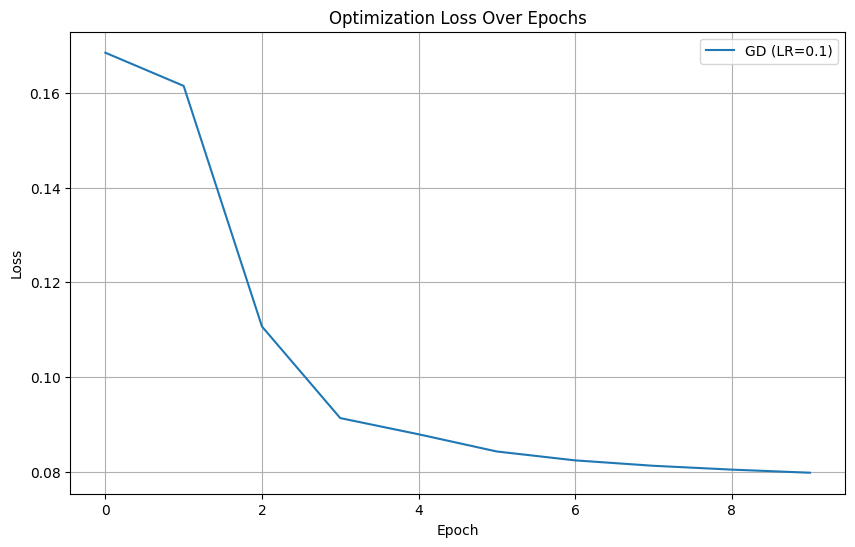

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label=f'GD (LR={lr})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimization Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Visual Comparison of Optimized Images


Visualizing Results...


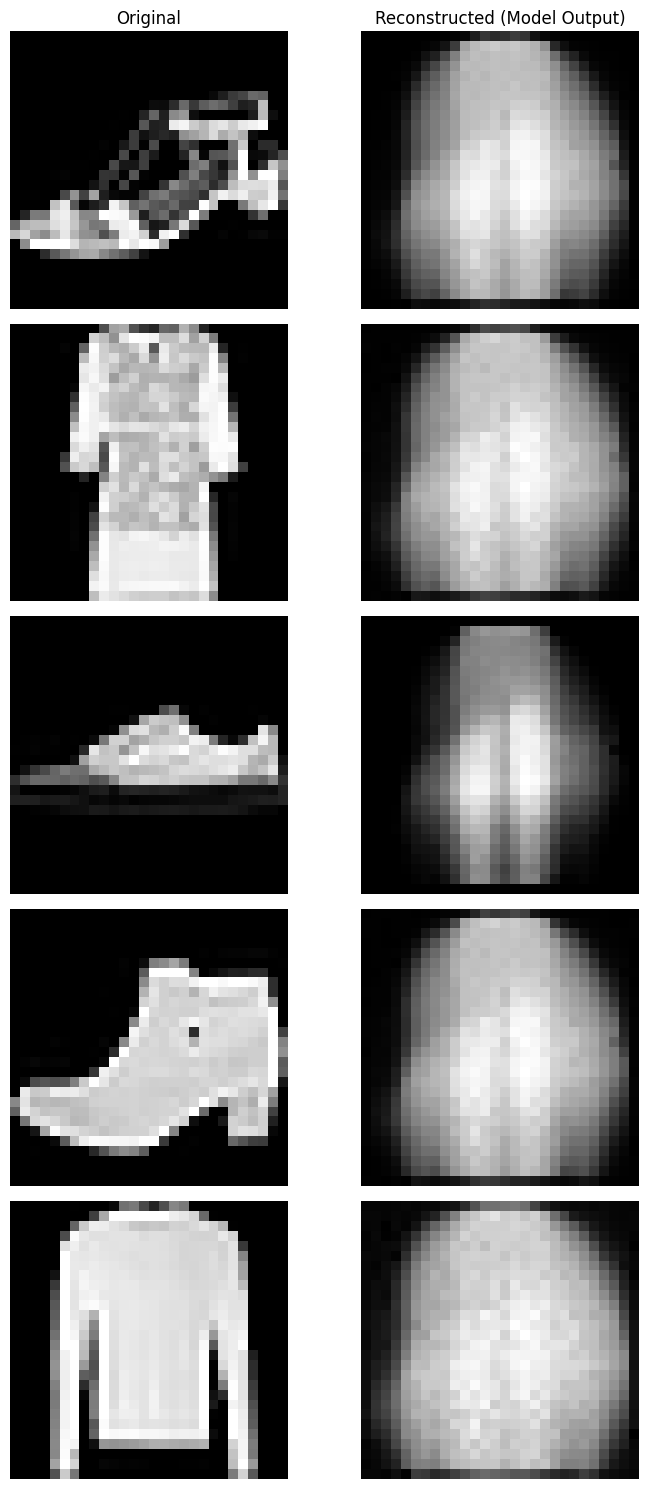

In [ ]:
def show_model_reconstructions(model, batch_images, count=5):
    """
    Visualizes original images vs. model reconstructions.
    """
    print("\nVisualizing Results...")

    model.eval()

    with torch.no_grad():
        inputs = batch_images[:count]
        reconstructions = model(inputs)

    plt.figure(figsize=(8, 3 * count))

    for i in range(count):
        img_orig = inputs[i].cpu().numpy().reshape(28, 28)
        img_recon = reconstructions[i].cpu().numpy().reshape(28, 28)

        # Original
        ax = plt.subplot(count, 2, i*2 + 1)
        plt.imshow(img_orig, cmap='gray')
        if i == 0: ax.set_title("Original")
        plt.axis('off')

        #Reconstructed
        ax = plt.subplot(count, 2, i*2 + 2)
        plt.imshow(img_recon, cmap='gray')
        if i == 0: ax.set_title("Reconstructed (Model Output)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# ---use example ---
data_iter = iter(train_loader)
sample_images = next(data_iter)[0]

show_model_reconstructions(trained_model, sample_images, count=5)

## Custom Optimizer Implementation
Variants: A1 (Adam+L2), B1-B8 (AdamW with different schedules)

In [6]:
# Import custom optimizers
import sys
sys.path.insert(0, 'src')

from optimizers.base import OptimizerConfig
from optimizers.adam_l2 import AdamL2
from optimizers.adamw import AdamW, AdamWConfig
from optimizers.schedulers import FixedLR, CosineLR, StepDropLR, WarmRestartsLR
from optimizers.adafactor import Adafactor, AdafactorConfig
from optimizers.combined import CombinedAdamWAdafactor, CombinedConfig

In [7]:
def create_optimizer(variant_id, model, epochs=100, batch_size=128, lr=1e-3, wd=1e-4,projection_spec="none", track_projection_metrics=False):
    """Create optimizer by variant ID."""
    total_steps = epochs * (len(x_train) // batch_size)
    total_batches = len(x_train) // batch_size * epochs

    variants = {
        'A1': lambda: AdamL2(model.parameters(), OptimizerConfig(lr=lr, weight_decay=wd)),
        'B1': lambda: AdamW(model.parameters(), AdamWConfig(lr=lr, weight_decay=wd), FixedLR(), total_steps),
        'B2': lambda: AdamW(model.parameters(), AdamWConfig(lr=lr, weight_decay=wd), StepDropLR(), total_steps),
        'B3': lambda: AdamW(model.parameters(), AdamWConfig(lr=lr, weight_decay=wd), CosineLR(), total_steps),
        'B4': lambda: AdamW(model.parameters(), AdamWConfig(lr=lr, weight_decay=wd), WarmRestartsLR(), total_steps),
        'B5': lambda: AdamW(model.parameters(), AdamWConfig(lr=lr, weight_decay=wd, normalized_decay=True, total_batches=total_batches), FixedLR(), total_steps),
        'B6': lambda: AdamW(model.parameters(), AdamWConfig(lr=lr, weight_decay=wd, normalized_decay=True, total_batches=total_batches), StepDropLR(), total_steps),
        'B7': lambda: AdamW(model.parameters(), AdamWConfig(lr=lr, weight_decay=wd, normalized_decay=True, total_batches=total_batches), CosineLR(), total_steps),
        'B8': lambda: AdamW(model.parameters(), AdamWConfig(lr=lr, weight_decay=wd, normalized_decay=True, total_batches=total_batches), WarmRestartsLR(), total_steps),
        'C1': lambda: Adafactor(
            model.parameters(),
            AdafactorConfig(
            lr=lr, beta1=0.0, weight_decay=wd,
            projection_spec=projection_spec,
            track_projection_metrics=track_projection_metrics,
            ),
            FixedLR(),
            total_steps
        ),
        'C2': lambda: Adafactor(
            model.parameters(),
            AdafactorConfig(
            lr=lr, beta1=0.9, weight_decay=wd,
            projection_spec=projection_spec,
            track_projection_metrics=track_projection_metrics,
            ),
            FixedLR(),
            total_steps
        ),

        'D1': lambda: CombinedAdamWAdafactor(
            model.parameters(),
            CombinedConfig(
                lr=lr, beta1=0.0, weight_decay=wd,
                normalized_decay=True, total_batches=total_batches
            ),
            CosineLR(),
            total_steps
        ),
        'D2': lambda: CombinedAdamWAdafactor(
            model.parameters(),
            CombinedConfig(
                lr=lr, beta1=0.0, weight_decay=wd,
                normalized_decay=True, total_batches=total_batches
            ),
            WarmRestartsLR(),
            total_steps
        ),
        'D3': lambda: CombinedAdamWAdafactor(
            model.parameters(),
            CombinedConfig(
                lr=lr, beta1=0.9, weight_decay=wd,
                normalized_decay=True, total_batches=total_batches
            ),
            WarmRestartsLR(),
            total_steps
        )
    }
    return variants[variant_id]()

VARIANT_NAMES = {
    'A1': 'Adam+L2', 'B1': 'AdamW Fixed', 'B2': 'AdamW StepDrop', 'B3': 'AdamW Cosine',
    'B4': 'AdamW WarmRestarts', 'B5': 'AdamW Fixed+Norm', 'B6': 'AdamW StepDrop+Norm',
    'B7': 'AdamW Cosine+Norm', 'B8': 'AdamW WarmRestarts+Norm'
        , 'C1': 'Adafactor (β1=0)', 'C2': 'Adafactor (β1=0.9)'
    , 'D1': 'Combined Cosine+Norm', 'D2': 'Combined WarmRestarts+Norm', 'D3': 'Combined WarmRestarts+Norm (β1=0.9)'
}

In [8]:
def train_with_custom_optimizer(model, criterion, train_loader, optimizer, epochs=100):
    """Training loop using custom optimizer with oracle."""
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            x = batch[0]
            loss, grads, _ = autoencoder_oracle(model, criterion, x, calc_hessian=False)
            for param, grad in zip(model.parameters(), grads):
                param.grad = grad
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')
    return losses

### Run Single Variant

In [ ]:
# Select variant and hyperparameters
VARIANT = 'B3'  # Options: A1, B1-B8
EPOCHS = 20
LR = 1e-3
WD = 1e-4

model = Autoencoder()
optimizer = create_optimizer(VARIANT, model, epochs=EPOCHS, lr=LR, wd=WD)
print(f'Training {VARIANT}: {VARIANT_NAMES[VARIANT]}')
losses = train_with_custom_optimizer(model, nn.MSELoss(), train_loader, optimizer, epochs=EPOCHS)

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label=f'{VARIANT}: {VARIANT_NAMES[VARIANT]}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Show reconstructions
show_model_reconstructions(model, next(iter(train_loader))[0], count=5)

## Grid Search for Heatmaps

In [9]:
from utils.logging import TrainingLog
from utils.experiment import GridSearchResult, OptimizerExperiment

# Hyperparameter grid
LR_MULTS = [1/1024, 1/512, 1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2]
WD_MULTS = [0, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32]
BASE_LR = 1e-3
BASE_WD = 1e-3

In [10]:
def run_single_config(variant_id, lr, wd, epochs, batch_size, test_loader=None, log_every=10):
    """Train one config and return detailed log with test evaluation."""
    import time

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = Autoencoder().to(device)
    opt = create_optimizer(variant_id, model, epochs=epochs, batch_size=batch_size, lr=lr, wd=wd)
    criterion = nn.MSELoss()

    x_train_dev = x_train.to(device)
    loader = DataLoader(TensorDataset(x_train_dev), batch_size=batch_size, shuffle=True)

    if test_loader:
        x_test_dev = test_loader.dataset.tensors[0].to(device)
        test_loader = DataLoader(TensorDataset(x_test_dev), batch_size=batch_size)

    log = TrainingLog()
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        epoch_loss = 0
        for batch in loader:
            x = batch[0]
            model.zero_grad()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        train_loss = epoch_loss / len(loader)

        # Evaluate on test set
        test_loss = train_loss
        if test_loader:
            model.eval()
            with torch.no_grad():
                test_loss = sum(criterion(model(b[0]), b[0]).item() for b in test_loader) / len(test_loader)
            model.train()

        log.log_epoch(train_loss, test_loss, time.time() - epoch_start)

    log.total_runtime = time.time() - start_time
    return model, log

In [11]:
def run_grid_search(variant_id, epochs=100, batch_size=128, save_every=1):
    """Run grid search with checkpointing and resume support."""
    filename = f'{variant_id}_{VARIANT_NAMES[variant_id].replace(" ", "_")}.json'
    filepath = RESULTS_DIR + filename

    # Try to resume from existing file
    try:
        experiment = OptimizerExperiment.load(filepath)
        done = {(r.lr_multiplier, r.wd_multiplier) for r in experiment.results}
        print(f'Resuming {variant_id}: {len(done)} configs already done')
    except:
        experiment = OptimizerExperiment(
            optimizer_id=variant_id,
            optimizer_name=VARIANT_NAMES[variant_id],
            config={'epochs': epochs, 'batch_size': batch_size, 'base_lr': BASE_LR, 'base_wd': BASE_WD}
        )
        done = set()

    test_loader = DataLoader(TensorDataset(x_test), batch_size=batch_size, shuffle=False)
    total = len(LR_MULTS) * len(WD_MULTS)

    for lr_mult in LR_MULTS:
        for wd_mult in WD_MULTS:
            if (lr_mult, wd_mult) in done:
                continue

            lr = BASE_LR * lr_mult
            wd = BASE_WD * wd_mult

            model, log = run_single_config(variant_id, lr, wd, epochs, batch_size, test_loader)

            experiment.results.append(GridSearchResult(
                lr_multiplier=lr_mult, wd_multiplier=wd_mult,
                learning_rate=lr, weight_decay=wd,
                final_train_loss=log.epoch_train_losses[-1],
                final_test_loss=log.epoch_test_losses[-1],
                best_test_loss=log.best_test_loss,
                best_epoch=log.best_epoch,
            ))

            n = len(experiment.results)
            print(f'\r{variant_id}: {n}/{total} | lr={lr:.2e}, wd={wd:.2e}, test={log.epoch_test_losses[-1]:.4f}', end='')

            if n % save_every == 0:
                experiment.save(filepath)

    print()
    experiment.save(filepath)
    return experiment

In [ ]:
# === CONFIGURATION ===
PHASE = 1  # 1 = screening (30 epochs), 2 = full training (100 epochs)

GRID_EPOCHS = 30 if PHASE == 1 else 100

# Phase 1: all optimizers for screening
# Phase 2: only winners (edit after Phase 1)
VARIANTS_TO_RUN = ['A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'C1', 'C2', 'D1', 'D2', 'D3']

print(f'Phase {PHASE}: {GRID_EPOCHS} epochs, {len(VARIANTS_TO_RUN)} optimizers')
print(f'Estimated time: ~{len(VARIANTS_TO_RUN) * 144 * GRID_EPOCHS / 50 * 6 / 60:.0f} hours')

experiments = {}
for v in VARIANTS_TO_RUN:
    print(f'\n=== {v}: {VARIANT_NAMES[v]} ===')
    experiments[v] = run_grid_search(v, epochs=GRID_EPOCHS)
    print(f'Saved to Drive: {v}')

In [ ]:
# Plot heatmaps (reloads from Drive if session disconnected)
from utils.experiment import OptimizerExperiment

# Reload experiments from Drive
experiments = {}
for v in VARIANTS_TO_RUN:
    filename = f'{v}_{VARIANT_NAMES[v].replace(" ", "_")}.json'
    filepath = RESULTS_DIR + filename
    try:
        experiments[v] = OptimizerExperiment.load(filepath)
        print(f'Loaded {v}: {len(experiments[v].results)}/144 configs')
    except Exception as e:
        print(f'Could not load {v}: {e}')

if not experiments:
    print("No experiments to plot!")
else:
    fig, axes = plt.subplots(1, len(experiments), figsize=(8*len(experiments), 6))
    if len(experiments) == 1:
        axes = [axes]

    for ax, (v, exp) in zip(axes, experiments.items()):
        exp.plot_heatmap(ax=ax, title=f'{v}: {exp.optimizer_name}')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR + 'heatmaps.png', dpi=150)
    plt.show()


### Load and Analyze Results Locally

In [ ]:
# Load saved results
# exp = OptimizerExperiment.load('results/A1_Adam+L2.json')
# exp.plot_heatmap()
# print(f'Best config: lr={min(exp.results, key=lambda r: r.best_test_loss)}')

## Adafactor Projection Test

This is a sandbox experiment to test projecting Adafactor's **factored second-moment running averages**
(`vr`, `vc`) onto different convex sets.

We run a short training (1 epoch for now) for C1 and C2 and log similarity metrics between `vr/vc` **before** and **after** projection (saved by the optimizer in `state["vr_pre_proj"]`, `state["vc_pre_proj"]`).


In [37]:
# --- runtime sweep specs (multiple L2 scales) ---

# Multipliers you want to sweep for adaptive L2-ball
L2_MULTS = [1e-12, 1e-10, 1e-8, 1e-6, 1e-4]
# For the box proj
BOX_US = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8]

# Build projection specs programmatically (no hardcoding) it is hardcoded
PROJECTION_SPECS = ["none"] #, "nonneg"] #, "box:l=0,u=1e6","box:l=0,u=1", "simplex:s=1.0"]
PROJECTION_SPECS += [f"l2_ball:scale=param_rms,base=1,mult={m}" for m in L2_MULTS]
PROJECTION_SPECS += [f"box:l=0,u={u}" for u in BOX_US]
# Alternative scale option:
# PROJECTION_SPECS += [f"l2_ball:scale=vec_rms,base=1000,mult={m}" for m in L2_MULTS]

print("Num projection specs:", len(PROJECTION_SPECS))
for s in PROJECTION_SPECS:
    print(" ", s)

Num projection specs: 15
  none
  nonneg
  box:l=0,u=1e6
  box:l=0,u=1
  simplex:s=1.0
  l2_ball:scale=param_rms,base=1,mult=1e-12
  l2_ball:scale=param_rms,base=1,mult=1e-10
  l2_ball:scale=param_rms,base=1,mult=1e-08
  l2_ball:scale=param_rms,base=1,mult=1e-06
  l2_ball:scale=param_rms,base=1,mult=0.0001
  box:l=0,u=1e-12
  box:l=0,u=1e-11
  box:l=0,u=1e-10
  box:l=0,u=1e-09
  box:l=0,u=1e-08


In [38]:
# =========================
# Adafactor Projection Test: RUN (replace this whole cell)
# =========================
import os, json, time
import numpy as np
import torch

# --- do NOT change blocks above; define locally only if missing ---
if "device" not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

RESULTS_DIR = "results/"
os.makedirs(RESULTS_DIR, exist_ok=True)

def _norm(x: torch.Tensor) -> float:
    return float(x.norm().item())

def _maybe(x: torch.Tensor):
    return x.detach() if torch.is_tensor(x) else x

# knobs for the projection experiment
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

EPOCHS_PROJ = 1
BATCH_SIZE_PROJ = 128
MAX_BATCHES = 200
LR_PROJ = 1e-3
WD_PROJ = 1e-4

# total_steps (only used if your Adafactor takes schedulers; define here anyway)
steps_per_epoch = max(1, len(x_train) // BATCH_SIZE_PROJ) if "x_train" in globals() else MAX_BATCHES
total_steps = EPOCHS_PROJ * steps_per_epoch

# loader (expects x_train exists from earlier blocks)
proj_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train),
    batch_size=BATCH_SIZE_PROJ,
    shuffle=True,
    drop_last=True,
)

def _cosine_sim(a: torch.Tensor, b: torch.Tensor, tol: float = 1e-12) -> float:
    a = a.flatten()
    b = b.flatten()
    na = float(a.norm().item())
    nb = float(b.norm().item())
    if na < tol or nb < tol:
        return float("nan")
    return float((a @ b).item() / (na * nb))

def _rel_change(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-12) -> float:
    denom = a.norm().clamp_min(eps)
    return float((b - a).norm() / denom)

def run_one_projection_spec(projection_spec: str, beta1: float):
    model = Autoencoder().to(device)
    criterion = torch.nn.MSELoss()

    # ---- Create optimizer WITHOUT touching blocks above ----
    # If you already have create_optimizer above and want to use it, use the first option.
    if "create_optimizer" in globals():
        opt = create_optimizer(
            "C1" if beta1 == 0.0 else "C2",
            model,
            epochs=EPOCHS_PROJ,
            batch_size=BATCH_SIZE_PROJ,
            lr=LR_PROJ,
            wd=WD_PROJ,
            projection_spec=projection_spec,
            track_projection_metrics=True,
        )
    else:
        # fallback: construct Adafactor directly (requires Adafactor/AdafactorConfig/WarmRestartsLR already imported above)
        opt = Adafactor(
            model.parameters(),
            AdafactorConfig(
                lr=LR_PROJ,
                weight_decay=WD_PROJ,
                beta1=beta1,
                projection_spec=projection_spec,
                track_projection_metrics=True,
            ),
            WarmRestartsLR(),
            total_steps,
        )

    step_metrics = []
    losses = []

    it = iter(proj_loader)
    for step in range(MAX_BATCHES):
        try:
            batch = next(it)[0].to(device)
        except StopIteration:
            it = iter(proj_loader)
            batch = next(it)[0].to(device)

        loss, grads, _ = autoencoder_oracle(model, criterion, batch, calc_hessian=False)

        for p, g in zip(model.parameters(), grads):
            p.grad = g

        opt.step()
        opt.zero_grad()

        losses.append(float(loss.item()))

        # pull projection stats from optimizer state (if you stored vr_pre_proj/vc_pre_proj)
        vr_rel, vc_rel, vr_cos, vc_cos = [], [], [], []
        vr_pre_norm, vr_post_norm, vc_pre_norm, vc_post_norm = [], [], [], []
        matched = 0

        state_dict = getattr(opt, "state", None)

        if isinstance(state_dict, dict):
            for st in state_dict.values():
                if not isinstance(st, dict):
                    continue

                if all(k in st for k in ("vr", "vc", "vr_pre_proj", "vc_pre_proj")):
                    matched += 1
                    vr_pre, vr_post = _maybe(st["vr_pre_proj"]), _maybe(st["vr"])
                    vc_pre, vc_post = _maybe(st["vc_pre_proj"]), _maybe(st["vc"])

                    # norms
                    vr_pre_norm.append(_norm(vr_pre))
                    vr_post_norm.append(_norm(vr_post))
                    vc_pre_norm.append(_norm(vc_pre))
                    vc_post_norm.append(_norm(vc_post))

                    # changes
                    vr_rel.append(_rel_change(vr_pre, vr_post))
                    vc_rel.append(_rel_change(vc_pre, vc_post))
                    vr_cos.append(_cosine_sim(vr_pre, vr_post))  # safe cosine
                    vc_cos.append(_cosine_sim(vc_pre, vc_post))


        step_metrics.append({
            "step": step,
            "loss": float(loss.item()),
            "matched_states": matched,

            "vr_pre_norm": float(np.nanmean(vr_pre_norm)) if vr_pre_norm else float("nan"),
            "vr_post_norm": float(np.nanmean(vr_post_norm)) if vr_post_norm else float("nan"),
            "vc_pre_norm": float(np.nanmean(vc_pre_norm)) if vc_pre_norm else float("nan"),
            "vc_post_norm": float(np.nanmean(vc_post_norm)) if vc_post_norm else float("nan"),

            "vr_rel": float(np.mean(vr_rel)) if vr_rel else float("nan"),
            "vc_rel": float(np.mean(vc_rel)) if vc_rel else float("nan"),
            "vr_cos": float(np.mean(vr_cos)) if vr_cos else float("nan"),
            "vc_cos": float(np.mean(vc_cos)) if vc_cos else float("nan"),
        })

    return {
        "projection_spec": projection_spec,
        "beta1": beta1,
        "loss_start": losses[0] if losses else None,
        "loss_end": losses[-1] if losses else None,
        "metrics": step_metrics,
    }

# --- run sweep ---
all_runs = []
t0 = time.time()

for spec in PROJECTION_SPECS:
    for beta1 in (0.0, 0.9):
        print(f"Running spec='{spec}' beta1={beta1} ...")
        all_runs.append(run_one_projection_spec(spec, beta1))

print("Done. total runs:", len(all_runs), "elapsed_sec:", time.time() - t0)

out_payload = {
    "meta": {
        "seed": SEED,
        "lr": LR_PROJ,
        "weight_decay": WD_PROJ,
        "max_batches": MAX_BATCHES,
        "batch_size": BATCH_SIZE_PROJ,
        "projection_specs": list(PROJECTION_SPECS),
    },
    "runs": all_runs,
}

out_path = os.path.join(RESULTS_DIR, "optimizer_projection_test.json")
with open(out_path, "w") as f:
    json.dump(out_payload, f, indent=2)

print("Saved:", out_path)


Running spec='none' beta1=0.0 ...
Running spec='none' beta1=0.9 ...
Running spec='nonneg' beta1=0.0 ...
Running spec='nonneg' beta1=0.9 ...
Running spec='box:l=0,u=1e6' beta1=0.0 ...
Running spec='box:l=0,u=1e6' beta1=0.9 ...
Running spec='box:l=0,u=1' beta1=0.0 ...
Running spec='box:l=0,u=1' beta1=0.9 ...
Running spec='simplex:s=1.0' beta1=0.0 ...
Running spec='simplex:s=1.0' beta1=0.9 ...
Running spec='l2_ball:scale=param_rms,base=1,mult=1e-12' beta1=0.0 ...
Running spec='l2_ball:scale=param_rms,base=1,mult=1e-12' beta1=0.9 ...
Running spec='l2_ball:scale=param_rms,base=1,mult=1e-10' beta1=0.0 ...
Running spec='l2_ball:scale=param_rms,base=1,mult=1e-10' beta1=0.9 ...
Running spec='l2_ball:scale=param_rms,base=1,mult=1e-08' beta1=0.0 ...
Running spec='l2_ball:scale=param_rms,base=1,mult=1e-08' beta1=0.9 ...
Running spec='l2_ball:scale=param_rms,base=1,mult=1e-06' beta1=0.0 ...
Running spec='l2_ball:scale=param_rms,base=1,mult=1e-06' beta1=0.9 ...
Running spec='l2_ball:scale=param_rms,

In [39]:
# =========================
# Adafactor Projection Test: SUMMARY (replace this whole cell)
# =========================
import pandas as pd
import numpy as np

def _safe(vals, fn, default=float("nan")):
    vals = [v for v in vals if not np.isnan(v)]
    return float(fn(vals)) if len(vals) else default

def _pct_active(vals, tol=1e-12):
    vals = [v for v in vals if not np.isnan(v)]
    if not vals:
        return float("nan")
    return 100.0 * float(np.mean([v > tol for v in vals]))

rows = []
for run in all_runs:
    metrics = run["metrics"]

    vr_pre_n = [m["vr_pre_norm"] for m in metrics]
    vr_post_n = [m["vr_post_norm"] for m in metrics]
    vc_pre_n = [m["vc_pre_norm"] for m in metrics]
    vc_post_n = [m["vc_post_norm"] for m in metrics]
    matched = [m["matched_states"] for m in metrics]

    vr_rel = [m["vr_rel"] for m in metrics]
    vc_rel = [m["vc_rel"] for m in metrics]
    vr_cos = [m["vr_cos"] for m in metrics]
    vc_cos = [m["vc_cos"] for m in metrics]
    losses = [m["loss"] for m in metrics]

    rows.append({
        "beta1": run["beta1"],
        "projection": run["projection_spec"],
        "steps": len(metrics),

        "vr_rel_mean": _safe(vr_rel, np.mean),
        "vr_rel_p95":  _safe(vr_rel, lambda z: np.percentile(z, 95)),
        "vr_rel_max":  _safe(vr_rel, np.max),
        "vr_active_%": _pct_active(vr_rel),

        "vc_rel_mean": _safe(vc_rel, np.mean),
        "vc_rel_p95":  _safe(vc_rel, lambda z: np.percentile(z, 95)),
        "vc_rel_max":  _safe(vc_rel, np.max),
        "vc_active_%": _pct_active(vc_rel),

        "vr_cos_mean": _safe(vr_cos, np.mean),
        "vr_cos_min":  _safe(vr_cos, np.min),
        "vc_cos_mean": _safe(vc_cos, np.mean),
        "vc_cos_min":  _safe(vc_cos, np.min),

        "loss_start": float(losses[0]) if losses else float("nan"),
        "loss_end":   float(losses[-1]) if losses else float("nan"),
        "matched_states_mean": _safe(matched, np.mean),

        "vr_pre_norm_mean": _safe(vr_pre_n, np.mean),
        "vr_post_norm_mean": _safe(vr_post_n, np.mean),
        "vc_pre_norm_mean": _safe(vc_pre_n, np.mean),
        "vc_post_norm_mean": _safe(vc_post_n, np.mean),

    })

df = pd.DataFrame(rows).sort_values(by=["beta1", "projection"]).reset_index(drop=True)
display(df)

# Optional: simple ranking (lower mean rel-change = "less intrusive projection")
rank = df.copy()
rank["score"] = rank["vr_rel_mean"].fillna(0) + rank["vc_rel_mean"].fillna(0)
rank = rank.sort_values(by=["beta1", "score"], ascending=[True, True]).reset_index(drop=True)
display(rank[["beta1", "projection", "score", "vr_rel_mean", "vc_rel_mean", "vr_active_%", "vc_active_%", "loss_end"]])


,beta1,projection,steps,vr_rel_mean,vr_rel_p95,vr_rel_max,vr_active_%,vc_rel_mean,vc_rel_p95,vc_rel_max,...,vr_cos_min,vc_cos_mean,vc_cos_min,loss_start,loss_end,matched_states_mean,vr_pre_norm_mean,vr_post_norm_mean,vc_pre_norm_mean,vc_post_norm_mean
0,0.0,"box:l=0,u=1",200,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.167440,0.169205,6.0,2.534424e-09,2.534424e-09,1.585288e-09,1.585288e-09
1,0.0,"box:l=0,u=1e-08",200,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.173084,0.165977,6.0,2.161803e-09,2.161803e-09,1.259594e-09,1.259594e-09
2,0.0,"box:l=0,u=1e-09",200,7.521221e-03,0.022620,9.461258e-02,100.0,3.589418e-03,0.010555,6.372707e-02,...,0.977733,0.999932,0.994600,0.170057,0.171322,6.0,1.927867e-09,1.912921e-09,1.307409e-09,1.302382e-09
3,0.0,"box:l=0,u=1e-10",200,6.399449e-02,0.195711,4.513849e-01,100.0,5.940768e-02,0.185531,4.864655e-01,...,0.884987,0.996655,0.899546,0.170880,0.173588,6.0,6.245025e-10,5.695546e-10,4.007302e-10,3.672376e-10
4,0.0,"box:l=0,u=1e-11",200,2.815176e-01,0.532220,8.070680e-01,100.0,2.697438e-01,0.533470,7.645293e-01,...,0.763494,0.961927,0.779905,0.170326,0.172437,6.0,1.394598e-10,8.335460e-11,9.859487e-11,6.377454e-11
5,0.0,"box:l=0,u=1e-12",200,6.997876e-01,0.886791,9.799144e-01,100.0,6.995329e-01,0.854887,9.585844e-01,...,0.618875,0.794344,0.659073,0.169236,0.165856,6.0,1.360660e-10,1.089492e-11,8.887698e-11,1.016928e-11
6,0.0,"box:l=0,u=1e6",200,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.167099,0.168706,6.0,2.524481e-09,2.524481e-09,1.903456e-09,1.903456e-09
7,0.0,"l2_ball:scale=param_rms,base=1,mult=0.0001",200,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.170543,0.167198,6.0,2.734572e-09,2.734572e-09,1.734238e-09,1.734238e-09
8,0.0,"l2_ball:scale=param_rms,base=1,mult=1e-06",200,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.172142,0.170000,6.0,2.234302e-09,2.234302e-09,1.482614e-09,1.482614e-09
9,0.0,"l2_ball:scale=param_rms,base=1,mult=1e-08",200,6.818761e-02,0.168765,3.483125e-01,99.5,4.300517e-02,0.121290,2.916704e-01,...,1.000000,1.000000,1.000000,0.168850,0.172670,6.0,5.470785e-10,4.789768e-10,5.033299e-10,4.680807e-10


,beta1,projection,score,vr_rel_mean,vc_rel_mean,vr_active_%,vc_active_%,loss_end
0,0.0,"box:l=0,u=1",0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.169205
1,0.0,"box:l=0,u=1e-08",0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.165977
2,0.0,"box:l=0,u=1e6",0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.168706
3,0.0,"l2_ball:scale=param_rms,base=1,mult=0.0001",0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.167198
4,0.0,"l2_ball:scale=param_rms,base=1,mult=1e-06",0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.170000
5,0.0,none,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.168290
6,0.0,nonneg,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.169203
7,0.0,"box:l=0,u=1e-09",1.111064e-02,7.521221e-03,3.589418e-03,100.0,100.0,0.171322
8,0.0,"l2_ball:scale=param_rms,base=1,mult=1e-08",1.111928e-01,6.818761e-02,4.300517e-02,99.5,99.5,0.172670
9,0.0,"box:l=0,u=1e-10",1.234022e-01,6.399449e-02,5.940768e-02,100.0,100.0,0.173588


These blocks are running the mild projection we found to have impact on the Adafactor vectors, for a training size we will be able to compare to the ones without any projections.

In [13]:
# =========================
# Projection specs: control / mild / extreme
# =========================

# Sweeps you already ran (keep for short diagnostics & write-up)
L2_MULTS_ALL = [1e-12, 1e-10, 1e-8, 1e-6, 1e-4]
BOX_US_ALL   = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8]

CONTROL_SPECS = [
    "none",
]

# Mild = activates but not overly destructive in your 200-step table:
# - L2 mult=1e-8 looked "mild"
# - Box u=1e-9 looked "mild"
MILD_SPECS = [
    "l2_ball:scale=param_rms,base=1,mult=1e-8",
    "box:l=0,u=1e-9",
]

# Extreme = intentionally strong; keep for write-up but do NOT long-run
EXTREME_SPECS = [
    "l2_ball:scale=param_rms,base=1,mult=1e-10",
    "l2_ball:scale=param_rms,base=1,mult=1e-12",
    "box:l=0,u=1e-11",
    "box:l=0,u=1e-12",
    "simplex:s=1.0",   # optional if you want the "stress test" example
]

# Optional: keep the full short-sweep list (for quick tests only)
SHORT_SWEEP_SPECS = (
    CONTROL_SPECS
    + [f"l2_ball:scale=param_rms,base=1,mult={m}" for m in L2_MULTS_ALL]
    + [f"box:l=0,u={u}" for u in BOX_US_ALL]
)

# Long runs: only baseline + mild (these are the ones you actually train longer)
LONG_RUN_SPECS = CONTROL_SPECS + MILD_SPECS

print("CONTROL:", CONTROL_SPECS)
print("MILD:", MILD_SPECS)
print("EXTREME (no long runs):", EXTREME_SPECS)
print("LONG_RUN_SPECS:", LONG_RUN_SPECS)


CONTROL: ['none']
MILD: ['l2_ball:scale=param_rms,base=1,mult=1e-8', 'box:l=0,u=1e-9']
EXTREME (no long runs): ['l2_ball:scale=param_rms,base=1,mult=1e-10', 'l2_ball:scale=param_rms,base=1,mult=1e-12', 'box:l=0,u=1e-11', 'box:l=0,u=1e-12', 'simplex:s=1.0']
LONG_RUN_SPECS: ['none', 'l2_ball:scale=param_rms,base=1,mult=1e-8', 'box:l=0,u=1e-9']


In [19]:
import os, json, time
import numpy as np
import torch

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from google.colab import drive
drive.mount('/content/drive')
# =========================
# Persistent save location (Google Drive)
# =========================
BASE_DIR = "/content/drive/MyDrive/adafactor_projection_test/"
RESULTS_DIR = os.path.join(BASE_DIR, "long_runs")

os.makedirs(RESULTS_DIR, exist_ok=True)

print("Saving long-run results to:", RESULTS_DIR)


# =========================
# Long run hyperparameters (comparable to sweep baseline)
# =========================
BATCH_SIZE = 128
LR = 0.002
WD = 3.125e-05

EPOCHS_LONG = 30       # recommended for "do we improve loss?"
MAX_STEPS_PER_EPOCH = None  # set to e.g. 200 if you want speed; otherwise full epoch



def run_long(projection_spec: str, beta1: float, seed: int = 0):
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = Autoencoder().to(device)
    criterion = torch.nn.MSELoss()

    # DataLoaders (assumes x_train, x_test exist)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train),
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test),
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
    )

    steps_per_epoch = len(train_loader) if MAX_STEPS_PER_EPOCH is None else min(len(train_loader), MAX_STEPS_PER_EPOCH)
    total_steps = EPOCHS_LONG * steps_per_epoch

    # Create optimizer (C1/C2 variants)
    opt = create_optimizer(
        "C1" if beta1 == 0.0 else "C2",
        model,
        epochs=EPOCHS_LONG,
        batch_size=BATCH_SIZE,
        lr=LR,
        wd=WD,
        projection_spec=projection_spec,
        track_projection_metrics=True,
    )

    def eval_loss():
        model.eval()
        losses = []
        with torch.no_grad():
            for (batch,) in test_loader:
                batch = batch.to(device)
                recon = model(batch)
                loss = criterion(recon, batch)
                losses.append(float(loss.item()))
        model.train()
        return float(np.mean(losses)) if losses else float("nan")

    history = []
    t0 = time.time()

    for epoch in range(EPOCHS_LONG):
        model.train()
        train_losses = []

        for i, (batch,) in enumerate(train_loader):
            if MAX_STEPS_PER_EPOCH is not None and i >= MAX_STEPS_PER_EPOCH:
                break

            batch = batch.to(device)
            loss, grads, _ = autoencoder_oracle(model, criterion, batch, calc_hessian=False)

            for p, g in zip(model.parameters(), grads):
                p.grad = g

            opt.step()
            opt.zero_grad()
            train_losses.append(float(loss.item()))

        train_loss = float(np.mean(train_losses)) if train_losses else float("nan")
        test_loss = eval_loss()

        history.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "test_loss": test_loss,
        })

        # optional: print progress
        if (epoch + 1) in (1, 5, 10, 20, 30, 50, 100) or (epoch + 1) == EPOCHS_LONG:
            print(f"[{projection_spec} | beta1={beta1}] epoch {epoch+1}/{EPOCHS_LONG} "
                  f"train={train_loss:.6f} test={test_loss:.6f}")

    elapsed = time.time() - t0

    # Save final weights
    weights_path = os.path.join(
        RESULTS_DIR,
        f"weights_beta1={beta1}_spec={projection_spec.replace(':','_').replace(',','_')}.pt"
    )
    torch.save({
        "model_state_dict": model.state_dict(),
        "seed": seed,
        "projection_spec": projection_spec,
        "beta1": beta1,
        "lr": LR,
        "wd": WD,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS_LONG,
        "max_steps_per_epoch": MAX_STEPS_PER_EPOCH,
    }, weights_path)

    # Save JSON history (for plots / reproducibility)
    out = {
        "meta": {
            "seed": seed,
            "beta1": beta1,
            "projection_spec": projection_spec,
            "lr": LR,
            "wd": WD,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS_LONG,
            "steps_per_epoch_used": steps_per_epoch,
            "elapsed_sec": elapsed,
            "weights_path": weights_path,
        },
        "history": history,
        "final": {
            "train_loss": history[-1]["train_loss"],
            "test_loss": history[-1]["test_loss"],
            "best_test_loss": min(h["test_loss"] for h in history),
            "best_epoch": int(np.argmin([h["test_loss"] for h in history]) + 1),
        }
    }

    json_path = os.path.join(
        RESULTS_DIR,
        f"run_beta1={beta1}_spec={projection_spec.replace(':','_').replace(',','_')}.json"
    )
    with open(json_path, "w") as f:
        json.dump(out, f, indent=2)

    return out, json_path, weights_path


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving long-run results to: /content/drive/MyDrive/adafactor_projection_test/long_runs


In [20]:
all_long = []
for beta1 in (0.0, 0.9):
    for spec in LONG_RUN_SPECS:
        out, jp, wp = run_long(spec, beta1, seed=0)
        all_long.append((out, jp, wp))

print("Done long runs. Saved to:", RESULTS_DIR)


[none | beta1=0.0] epoch 1/30 train=0.170627 test=0.169811
[none | beta1=0.0] epoch 5/30 train=0.168837 test=0.167941
[none | beta1=0.0] epoch 10/30 train=0.164713 test=0.163481
[none | beta1=0.0] epoch 20/30 train=0.136115 test=0.133436
[none | beta1=0.0] epoch 30/30 train=0.096238 test=0.094549
[l2_ball:scale=param_rms,base=1,mult=1e-8 | beta1=0.0] epoch 1/30 train=0.170583 test=0.169725
[l2_ball:scale=param_rms,base=1,mult=1e-8 | beta1=0.0] epoch 5/30 train=0.168453 test=0.167497
[l2_ball:scale=param_rms,base=1,mult=1e-8 | beta1=0.0] epoch 10/30 train=0.163243 test=0.161799
[l2_ball:scale=param_rms,base=1,mult=1e-8 | beta1=0.0] epoch 20/30 train=0.126145 test=0.123060
[l2_ball:scale=param_rms,base=1,mult=1e-8 | beta1=0.0] epoch 30/30 train=0.087289 test=0.085730
[box:l=0,u=1e-9 | beta1=0.0] epoch 1/30 train=0.170626 test=0.169809
[box:l=0,u=1e-9 | beta1=0.0] epoch 5/30 train=0.168790 test=0.167869
[box:l=0,u=1e-9 | beta1=0.0] epoch 10/30 train=0.162181 test=0.160164
[box:l=0,u=1e-9 